In [2]:
"""
Unified UTA Pipeline: Monotonic and Non-Monotonic Implementation
Based on Ghaderi et al. (2017) EJOR paper
"""

import numpy as np
from typing import Sequence, Optional, Dict, Any, Tuple, List
from gurobipy import Model, GRB, LinExpr
import warnings

In [3]:
# ==================== SCALING UTILITIES ====================

def _scale_matrix(X: np.ndarray, mode: Optional[str]) -> Tuple[np.ndarray, Dict[str, Any]]:
    """
    Column-wise scaling.
    mode in {None, 'minmax', 'sym', 'zscore'}:
      - minmax/unitrange: [0,1]
      - sym: [-1,1]
      - zscore: (x-mean)/std (breaks built on observed min/max of z)
    """
    X = np.asarray(X, dtype=float)
    n, m = X.shape
    meta = {"mode": mode, "params": []}
    if mode is None:
        return X.copy(), meta

    Xs = np.empty_like(X)
    for j in range(m):
        col = X[:, j].astype(float)
        if mode in ("minmax", "unitrange"):
            mn, mx = float(col.min()), float(col.max())
            rng = mx - mn if mx > mn else 1.0
            Xs[:, j] = (col - mn) / rng
            meta["params"].append({"min": mn, "max": mx})
        elif mode == "sym":
            mn, mx = float(col.min()), float(col.max())
            rng = mx - mn if mx > mn else 1.0
            Xs[:, j] = 2.0 * (col - mn) / rng - 1.0
            meta["params"].append({"min": mn, "max": mx})
        elif mode == "zscore":
            mu, sd = float(col.mean()), float(col.std(ddof=0))
            sd = sd if sd > 0 else 1.0
            Xs[:, j] = (col - mu) / sd
            meta["params"].append({"mean": mu, "std": sd})
        else:
            raise ValueError("Unknown scaling mode.")
    return Xs, meta


def _scale_with_info(X, scale_info):
    """Apply scaling using stored scale_info parameters"""
    mode = scale_info.get("mode")
    if not mode:
        return X
    X = np.asarray(X, dtype=float).copy()
    params = scale_info["params"]
    for j in range(X.shape[1]):
        if mode in ("minmax", "unitrange"):
            mn, mx = params[j]["min"], params[j]["max"]
            rng = (mx - mn) if mx > mn else 1.0
            X[:, j] = (X[:, j] - mn) / rng
        elif mode == "sym":
            mn, mx = params[j]["min"], params[j]["max"]
            rng = (mx - mn) if mx > mn else 1.0
            X[:, j] = 2.0 * (X[:, j] - mn) / rng - 1.0
        elif mode == "zscore":
            mu, sd = params[j]["mean"], params[j]["std"]
            sd = sd if sd > 0 else 1.0
            X[:, j] = (X[:, j] - mu) / sd
        else:
            raise ValueError("Unknown scaling mode in scale_info.")
    return X

In [4]:
# ==================== BREAKPOINT & INTERPOLATION ====================

def _build_breaks(minv: float, maxv: float, L: int) -> np.ndarray:
    """Build L equidistant breakpoints between minv and maxv"""
    if L < 2:
        raise ValueError("L must be >= 2.")
    return np.linspace(minv, maxv, L)


def _interp_expr(m: Model, x: float, brk: np.ndarray, uvars: List[Any]) -> LinExpr:
    """
    Linear interpolation of u(x) over breakpoints brk and decision values uvars.
    Returns a Gurobi affine expression.
    """
    if x <= brk[0]:
        return LinExpr(uvars[0])
    if x >= brk[-1]:
        return LinExpr(uvars[-1])

    j = np.searchsorted(brk, x) - 1
    j = max(0, min(j, len(brk)-2))
    x0, x1 = float(brk[j]), float(brk[j+1])
    w1 = (x - x0) / (x1 - x0)
    w0 = 1.0 - w1
    expr = LinExpr()
    expr.addTerms([w0, w1], [uvars[j], uvars[j+1]])
    return expr

In [5]:
# ==================== GROUND TRUTH GENERATOR ====================

def uta_gt(
    X: np.ndarray,
    L: int,
    seed: Optional[int] = None,
    weights_dirichlet_alpha: float = 1.0,
    increments_dirichlet_alpha: float = 1.0,
    scale: Optional[str] = "minmax",
    non_monotonic_criteria: Optional[List[int]] = None,
    non_monotonic_complexity: int = 2,
) -> Dict[str, Any]:
    """
    Generate additive model (monotonic or non-monotonic).

    For MONOTONIC criteria:
      - weights w ~ Dirichlet(alpha)
      - each marginal u_k is PWL with L points; increments ~ Dirichlet => monotone
      - u_k(min)=0, u_k(max)=1

    For NON-MONOTONIC criteria (Ghaderi et al. approach):
      - Generate "sweet spot" marginals (inverted-U or U-shaped)
      - Complexity controlled by non_monotonic_complexity parameter

    Parameters
    ----------
    X : np.ndarray, shape (n, m)
        Alternatives data
    L : int
        Number of breakpoints per criterion
    non_monotonic_criteria : List[int], optional
        Indices of criteria that should be non-monotonic
    non_monotonic_complexity : int
        Degree of non-monotonicity (1=linear, 2=quadratic/sweet-spot, etc.)

    Returns
    -------
    dict with: weights, u_values (m x L), breaks, scores, ranking, is_monotonic (per criterion)
    """
    rng = np.random.default_rng(seed)
    X = np.asarray(X, dtype=float)
    n, m = X.shape


    if non_monotonic_criteria is None:
        non_monotonic_criteria = [j for j in range(m) if rng.random() < 0.5]

    # print(f"Non-monotonic criteria indices: {non_monotonic_criteria}")
    Xs, scale_info = _scale_matrix(X, scale)
    breaks = [_build_breaks(Xs[:, j].min(), Xs[:, j].max(), L) for j in range(m)]

    w = rng.dirichlet(np.full(m, weights_dirichlet_alpha))
    u_values = np.zeros((m, L))
    is_monotonic = np.ones(m, dtype=bool)

    for j in range(m):
        # if j in non_monotonic_criteria:
        #     # NON-MONOTONIC: Generate "sweet spot" (inverted-U shape)
        #     is_monotonic[j] = False
        #     # Use polynomial to create sweet-spot shape
        #     t = np.linspace(0, 1, L)
        #     if non_monotonic_complexity == 2:
        #         coeffs = rng.uniform(-1, 1, non_monotonic_complexity + 1)
        #         poly = np.poly1d(coeffs)
        #         u_raw = poly(t)

        #         # Normalisation interne
        #         u_raw -= u_raw.min()
        #         if u_raw.max() > 0:
        #             u_raw /= u_raw.max()

        #         # Optionnel: remapper dans [a,b]
        #         a = rng.uniform(0.0, 0.4)
        #         b = rng.uniform(0.6, 1.3)
        #         u_values[j] = a + (b - a) * u_raw

        if j in non_monotonic_criteria:
            is_monotonic[j] = False
            t = np.linspace(0, 1, L)

            # Choisir aléatoirement concave ou convexe
            if rng.random() < 0.5:
                # ---------- CONCAVE (bosse) ----------
                peak = rng.uniform(0.2, 0.8)
                raw = - (t - peak)**2   # parabole concave
            else:
                # ---------- CONVEXE (creux) ----------
                peak = rng.uniform(0.2, 0.8)
                raw = (t - peak)**2    # parabole convexe

            # Normalisation stricte [0,1]
            raw -= raw.min()
            if raw.max() > 0:
                raw /= raw.max()

            u_values[j, :] = raw


        # if j in non_monotonic_criteria:
        #     is_monotonic[j] = False

        #     while True:
        #         t = np.linspace(0, 1, L)

        #         # --- sweet spot aléatoire (pic ≠ toujours au milieu) ---
        #         peak = rng.uniform(0.2, 0.8)       # position du pic
        #         width = rng.uniform(3.0, 10.0)     # largeur de la bosse
        #         raw = np.exp(-width * (t - peak)**2)

        #         # normalisation interne [0,1]
        #         raw -= raw.min()
        #         if raw.max() > 0:
        #             raw /= raw.max()

        #         # test de monotonie
        #         d = np.diff(raw)
        #         if np.all(d >= 0) or np.all(d <= 0):
        #             # encore monotone → on régénère
        #             continue

        #         u_values[j, :] = raw
        #         break

        else:
            # MONOTONIC: Standard UTA approach
            inc = rng.dirichlet(np.full(L-1, increments_dirichlet_alpha))
            u_values[j, 0] = 0.0
            u_values[j, 1:] = np.cumsum(inc)

    # Compute scores
    scores = np.zeros(n)
    for a in range(n):
        s = 0.0
        for j in range(m):
            x = float(Xs[a, j])
            brk = breaks[j]
            if x <= brk[0]:
                u = u_values[j, 0]
            elif x >= brk[-1]:
                u = u_values[j, -1]
            else:
                t = np.searchsorted(brk, x) - 1
                t = max(0, min(t, L-2))
                lam = (x - brk[t]) / (brk[t+1] - brk[t])
                u = (1 - lam) * u_values[j, t] + lam * u_values[j, t+1]
            s += w[j] * u
        scores[a] = s

    order = np.argsort(-scores).tolist()
    return {
        "scale_info": scale_info,
        "breaks": breaks,
        "u_values": u_values,
        "weights": w,
        "scores": scores,
        "ranking": order,
        "is_monotonic": is_monotonic,
        "non_monotonic_criteria": non_monotonic_criteria,
    }

In [6]:
def uta_inf(
    X: np.ndarray,
    order: Optional[Sequence[int]],
    L: int,
    scale: Optional[str] = "minmax",
    eps: float = 1e-2,
    min_increment: float = 0.0,
    assume_rows_are_ordered: bool = False,
    use_non_monotonic: bool = False,
    gamma_weight: float = 0.5,
    gamma_upper_bound: float = 2.0,
    epsilon_lb: float = 0.01,
    epsilon_ub: float = 0.5,
    gurobi_params: Optional[Dict[str, Any]] = None,
    verbose: bool = False,
) -> Dict[str, Any]:
    """

    - use_non_monotonic = False : UTA classique monotone (comme avant)
    - use_non_monotonic = True  : tous les critères sont potentiellement non monotones
        * pas d'info a priori critère par critère
        * contrôle de complexité via gamma (variation de pente)
        * epsilon variable bornée [epsilon_lb, epsilon_ub]

    Outputs principaux :
      - scores, ranking
      - breaks, u_values (m x L), weights (= u_{j,L-1})
      - gamma_values (si non-monotone), epsilon, method_used
    """
    X = np.asarray(X, dtype=float)
    n, m = X.shape

    # ----- Ordre -----
    if order is None:
        if not assume_rows_are_ordered:
            raise ValueError("Provide a strict 'order' or set assume_rows_are_ordered=True.")
        order = list(range(n))
    else:
        order = list(order)
        if len(order) != n or len(set(order)) != n:
            raise ValueError("`order` must be a permutation of range(n) with no duplicates (strict).")

    # ----- Scaling & breakpoints -----
    Xs, scale_info = _scale_matrix(X, scale)
    breaks = [_build_breaks(Xs[:, j].min(), Xs[:, j].max(), L) for j in range(m)]

    model = Model("UTA_Unified_Agnostic")
    if not verbose:
        model.setParam("OutputFlag", 0)
    if gurobi_params:
        for k, v in gurobi_params.items():
            model.setParam(k, v)

    # ----- Variables u_{j,l} -----
    u = []
    for j in range(m):
        if use_non_monotonic:
            # non-monotone : borné [0,1] pour stabilité, pas de monotonie imposée
            uj = [model.addVar(lb=0.0, ub=1.0, name=f"u_{j}_{l}") for l in range(L)]
        else:
            # monotone classique : u >= 0, pas de borne sup
            uj = [model.addVar(lb=0.0, name=f"u_{j}_{l}") for l in range(L)]
        u.append(uj)

    # slacks (bruit / incohérences)
    o = [model.addVar(lb=0.0, name=f"o_{a}") for a in range(n)]

    # epsilon variable seulement en mode non-monotone
    if use_non_monotonic:
        epsilon_var = model.addVar(lb=epsilon_lb, ub=epsilon_ub, name="epsilon")
    else:
        epsilon_var = None  # on garde le paramètre eps

    # gamma pour contrôle de variation de pente (seulement non-monotone)
    gamma = []
    if use_non_monotonic and L > 2:
        for j in range(m):
            gamma_j = [
                model.addVar(lb=0.0, ub=gamma_upper_bound, name=f"gamma_{j}_{l}")
                for l in range(1, L - 1)  # breakpoints intérieurs
            ]
            gamma.append(gamma_j)
    else:
        gamma = [[] for _ in range(m)]

    model.update()

    # ----- Contraintes -----

    # # 1) Normalisation u_{j,0} = 0
    # for j in range(m):
    #     model.addConstr(u[j][0] == 0.0, name=f"norm_min_{j}")

    # 2) Monotonicité (seulement mode monotone)
    if not use_non_monotonic:
        for j in range(m):
            for l in range(L - 1):
                model.addConstr(
                    u[j][l + 1] - u[j][l] >= min_increment,
                    name=f"mono_{j}_{l}",
                )

    # 3) Variation de pente (gamma) pour tous les critères en mode non-monotone
    if use_non_monotonic and L > 2:
        for j in range(m):
            brk = breaks[j]
            for idx_l, l in enumerate(range(1, L - 1)):
                delta_left = float(brk[l] - brk[l - 1])
                delta_right = float(brk[l + 1] - brk[l])

                slope_left = (u[j][l] - u[j][l - 1]) / delta_left
                slope_right = (u[j][l + 1] - u[j][l]) / delta_right
                slope_diff = slope_right - slope_left

                gvar = gamma[j][idx_l]
                model.addConstr(slope_diff <= gvar, name=f"gamma_u_{j}_{l}")
                model.addConstr(-slope_diff <= gvar, name=f"gamma_l_{j}_{l}")

    # 4) Normalisation des poids : sum_j max_j = 1
    model.addConstr(sum(u[j][-1] for j in range(m)) == 1.0, name="sum_weights")

    # 5) Utilities
    U = []
    for a in range(n):
        expr = LinExpr()
        for j in range(m):
            expr += _interp_expr(model, float(Xs[a, j]), breaks[j], u[j])
        U.append(expr)

    # 6) Contraintes d’ordre adjacent
    for k in range(n - 1):
        a, b = order[k], order[k + 1]
        if use_non_monotonic:
            # U[a] - U[b] >= epsilon - (o[a] - o[b])
            model.addConstr(
                U[a] - U[b] >= epsilon_var + o[b] - o[a],
                name=f"adj_strict_{a}_{b}",
            )
        else:
            # U[a] - U[b] >= eps - (o[a] - o[b])  (eps param constant)
            model.addConstr(
                U[a] - U[b] >= eps + o[b] - o[a],
                name=f"adj_strict_{a}_{b}",
            )

    # ----- Objectif -----
    if use_non_monotonic and L > 2:
        total_gamma = sum(sum(gamma_j) for gamma_j in gamma)
        total_slacks = sum(o)
        # proxy de (sum gamma)/epsilon
        obj = gamma_weight * total_gamma - (1.0 - gamma_weight) * epsilon_var + total_slacks
        model.setObjective(obj, GRB.MINIMIZE)
    else:
        # UTA classique : minimiser les slacks
        model.setObjective(sum(o), GRB.MINIMIZE)

    model.optimize()

    if model.Status not in (GRB.OPTIMAL, GRB.SUBOPTIMAL):
        return {
            "status": model.Status,
            "obj": None,
            "scores": None,
            "ranking": None,
            "breaks": breaks,
            "u_values": None,
            "weights": None,
            "gamma_values": None,
            "epsilon": None,
            "method_used": "non-monotonic" if use_non_monotonic else "monotonic",
            "scale_info": scale_info,
        }

    # ----- Extraction -----
    u_values = np.zeros((m, L))
    for j in range(m):
        for l in range(L):
            u_values[j, l] = u[j][l].X

    gamma_values = None
    if use_non_monotonic and L > 2:
        gamma_values = np.zeros((m, L - 2))
        for j in range(m):
            for idx_l, l in enumerate(range(1, L - 1)):
                gamma_values[j, idx_l] = gamma[j][idx_l].X

    # scores = somme des utilités pondérées par le "max" (weights)
    scores = np.zeros(n)
    for a in range(n):
        s = 0.0
        for j in range(m):
            x = float(Xs[a, j])
            brk = breaks[j]
            if x <= brk[0]:
                u_val = u_values[j, 0]
            elif x >= brk[-1]:
                u_val = u_values[j, -1]
            else:
                t = np.searchsorted(brk, x) - 1
                t = max(0, min(t, L - 2))
                lam = (x - brk[t]) / (brk[t + 1] - brk[t])
                u_val = (1.0 - lam) * u_values[j, t] + lam * u_values[j, t + 1]
            s += u_values[j, -1] * u_val
        scores[a] = s

    inferred_order = np.argsort(-scores).tolist()
    weights = u_values[:, -1]

    return {
        "status": model.Status,
        "obj": model.ObjVal,
        "scores": scores,
        "ranking": inferred_order,
        "breaks": breaks,
        "u_values": u_values,
        "weights": weights,
        "gamma_values": gamma_values,
        "epsilon": float(epsilon_var.X) if use_non_monotonic and epsilon_var is not None else None,
        "method_used": "non-monotonic" if use_non_monotonic else "monotonic",
        "scale_info": scale_info,
    }


In [7]:
# ==================== SCORING FUNCTION ====================

def make_scoring_fn(model):
    """
    Create scoring function from inferred model.
    Works for both monotonic and non-monotonic models.
    """
    w = np.asarray(model["weights"])
    uvals = np.asarray(model["u_values"])
    brks = model["breaks"]
    sinfo = model.get("scale_info", {"mode": None})

    def U(X):
        X = np.atleast_2d(X).astype(float)
        Xs = _scale_with_info(X, sinfo)

        scores = np.zeros(X.shape[0])
        for j in range(X.shape[1]):
            uj = np.interp(Xs[:, j], brks[j], uvals[j])
            scores += w[j] * uj
        return scores

    return U

In [8]:
# ==================== VISUALIZATION ====================

def plot_value_functions(gt: dict, res: dict, mode: str = "weighted"):
    """
    Plot value functions (True vs Inferred) with support for non-monotonic shapes.

    Parameters
    ----------
    mode : {"weighted", "shape"}
        - "weighted": plot w_j * u_j(x)
        - "shape": normalize each marginal by its max
    """
    import matplotlib.pyplot as plt

    m = len(gt["breaks"])
    if m != len(res["breaks"]):
        raise ValueError("Mismatch in number of criteria.")

    rows = (m + 1) // 2
    fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(12, 3*rows))
    axes = np.ravel(axes) if rows > 1 else np.array([axes]).ravel()

    for j, ax in enumerate(axes[:m]):
        # True
        x_true = np.asarray(gt["breaks"][j], float)
        u_true = np.asarray(gt["u_values"][j], float)
        # Inferred
        x_inf = np.asarray(res["breaks"][j], float)
        u_inf = np.asarray(res["u_values"][j], float)

        if mode == "weighted":
            w_t = float(gt["weights"][j])
            w_i = float(res["weights"][j])
            y_true = w_t * u_true
            y_inf = w_i * u_inf
            y_label = r"$w_j \cdot u_j(x)$"
            title_suffix = "Weighted"
        elif mode == "shape":
            y_true = u_true / (u_true.max() if u_true.max() > 0 else 1.0)
            y_inf = u_inf / (u_inf.max() if u_inf.max() > 0 else 1.0)
            y_label = "Normalized partial utility"
            title_suffix = "Shape"
        else:
            raise ValueError("mode must be 'weighted' or 'shape'.")

        # Plot
        ax.plot(x_true, y_true, marker='o', linewidth=2, label='True')
        ax.plot(x_inf, y_inf, marker='s', linestyle='--', linewidth=2, label='Inferred')

        # Add monotonicity indicator
        is_mono_gt = gt.get("is_monotonic", np.ones(m, dtype=bool))[j]
        is_mono_inf = res.get("is_monotonic", np.ones(m, dtype=bool))[j]
        mono_str = ""
        if not is_mono_gt:
            mono_str = " [GT: Non-mono]"
        if not is_mono_inf:
            mono_str += " [Inf: Non-mono]"

        ax.set_title(f"C{j+1} ({title_suffix}){mono_str}", fontsize=10)
        ax.set_xlim(x_true.min(), x_true.max())
        ymax = max(y_true.max(), y_inf.max()) if y_true.size and y_inf.size else 1.0
        ax.set_ylim(0, 1.1 * ymax if ymax > 0 else 1.0)
        ax.set_xlabel("Criterion value (scaled)")
        ax.set_ylabel(y_label)
        ax.grid(True, alpha=0.3)
        ax.legend()

    for ax in axes[m:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def plot_weights(gt: dict, res: dict):
    """Side-by-side bar plot of True vs Inferred weights"""
    import matplotlib.pyplot as plt

    w_true = np.asarray(gt["weights"], float)
    w_inf = np.asarray(res["weights"], float)
    if w_true.shape != w_inf.shape:
        raise ValueError("Weight vectors have different shapes.")

    m = len(w_true)
    idx = np.arange(m)
    barw = 0.35

    plt.figure(figsize=(8, 4))
    plt.bar(idx - barw/2, w_true, width=barw, label="True")
    plt.bar(idx + barw/2, w_inf, width=barw, label="Inferred")
    plt.xticks(idx, [f"C{i+1}" for i in range(m)])
    plt.xlabel("Criterion")
    plt.ylabel("Weight")
    plt.title("Weights: True vs Inferred")
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_gamma_heatmap(res: dict):
    """
    Visualize slope variation (gamma values) for non-monotonic inference.
    Shows which breakpoints have the most slope variation.
    """
    import matplotlib.pyplot as plt

    if res.get("gamma_values") is None:
        print("No gamma values available (monotonic inference or not computed)")
        return

    gamma_vals = res["gamma_values"]
    m, L_minus_1 = gamma_vals.shape

    fig, ax = plt.subplots(figsize=(10, max(3, m * 0.6)))
    im = ax.imshow(gamma_vals, aspect='auto', cmap='YlOrRd')

    ax.set_xticks(np.arange(L_minus_1))
    ax.set_yticks(np.arange(m))
    ax.set_xticklabels([f"BP{l}" for l in range(1, L_minus_1+1)])
    ax.set_yticklabels([f"C{j+1}" for j in range(m)])
    ax.set_xlabel("Breakpoint")
    ax.set_ylabel("Criterion")
    ax.set_title("Slope Variation (Gamma) Heatmap")

    plt.colorbar(im, ax=ax, label="Gamma value")
    plt.tight_layout()
    plt.show()

In [9]:
def pairwise_agreement_once(
    n=100, m=4, L=5, n_pairs=10_000,
    seed=None,
    use_non_monotonic=False,      # comment on INFÈRE
    gt_mode: str = "monotonic",   # comment on GÉNÈRE le GT: "monotonic" ou "mixed"
):
    """
    Single run: GT -> INF -> evaluate on n_pairs -> compute agreement.

    gt_mode:
      - "monotonic" : tous les critères GT monotones
      - "mixed"     : critères mono / non-mono selon uta_gt (50% si None)
    """
    rng = np.random.default_rng(seed)

    X = rng.integers(0, 1000, size=(n, m))

    # --- Ground truth ---
    if gt_mode == "monotonic":
        # on force tous les critères monotones
        non_mono_criteria = []
    elif gt_mode == "mixed":
        # on laisse uta_gt décider (ta logique 50/50)
        non_mono_criteria = None
    else:
        raise ValueError(f"Unknown gt_mode: {gt_mode}")

    gt = uta_gt(
        X, L=L,
        seed=int(rng.integers(0, 1_000_000)),
        non_monotonic_criteria=non_mono_criteria,
    )
    U_gt = make_scoring_fn(gt)
    ranking_ref = gt["ranking"]

    # --- Inference ---
    inf = uta_inf(
        X,
        order=ranking_ref,
        L=L,
        eps=1e-4,                 # utilisé seulement en mode monotone
        use_non_monotonic=use_non_monotonic,
    )
    U_inf = make_scoring_fn(inf)

    # --- Test pairs ---
    XY = rng.integers(0, 1000, size=(n_pairs, 2, m))
    Xp, Yp = XY[:, 0, :], XY[:, 1, :]

    cmp_gt = np.sign(U_gt(Xp) - U_gt(Yp))
    cmp_inf = np.sign(U_inf(Xp) - U_inf(Yp))

    return float((cmp_gt == cmp_inf).mean())


def run_protocol(
    n=100, m=4, L=5, n_pairs=10_000, repeats=30, seed=42,
    use_non_monotonic=False,
    gt_mode: str = "monotonic",
):
    """
    Complete protocol: multiple repetitions with confidence intervals.
    gt_mode : "monotonic" ou "mixed" (cf. pairwise_agreement_once).
    """
    rng = np.random.default_rng(seed)
    accs = [
        pairwise_agreement_once(
            n=n, m=m, L=L, n_pairs=n_pairs,
            seed=int(rng.integers(0, 1_000_0)),
            use_non_monotonic=use_non_monotonic,
            gt_mode=gt_mode,
        )
        for _ in range(repeats)
    ]
    accs = np.array(accs)
    return {
        "mean_acc": float(accs.mean()),
        "std_acc": float(accs.std(ddof=1)),
        "runs": repeats,
        "per_run": accs.tolist(),
    }


MONOTONIC UTA
Ground truth weights: [0.408 0.45  0.083 0.059]
Ground truth ranking (top 10): [92, 60, 17, 64, 99, 34, 37, 3, 43, 81]
Restricted license - for non-production use only - expires 2026-11-23

Inferred weights: [0.327 0.574 0.092 0.006]
Optimization status: 2
Objective value: 8.918839
Inferred ranking (top 10): [92, 60, 64, 17, 99, 37, 34, 3, 43, 87]

Generating visualizations...


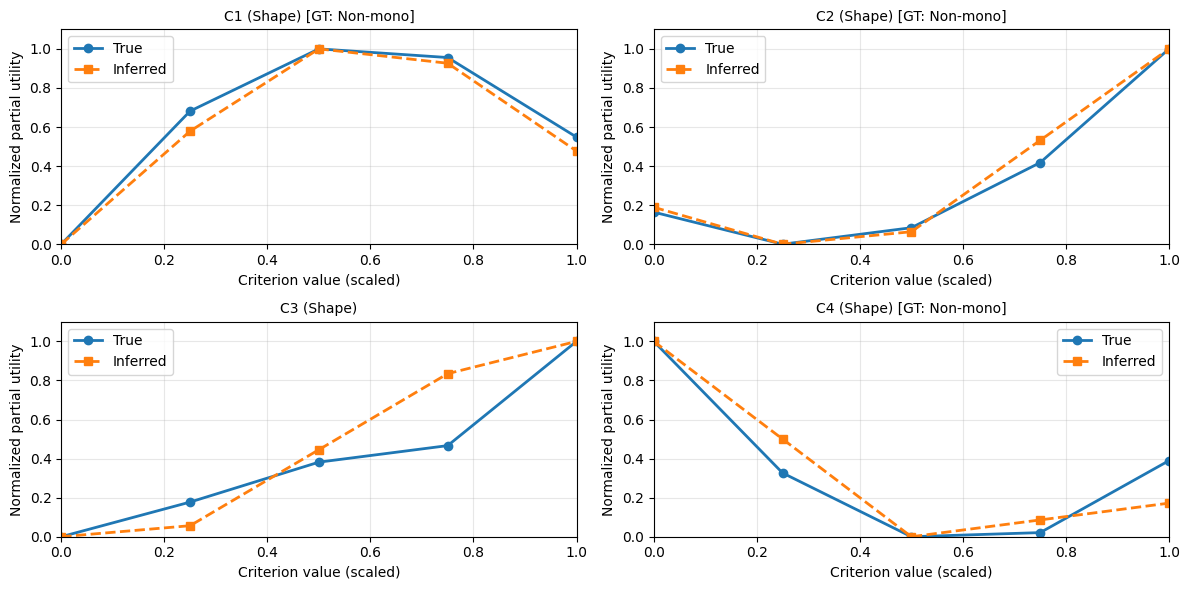

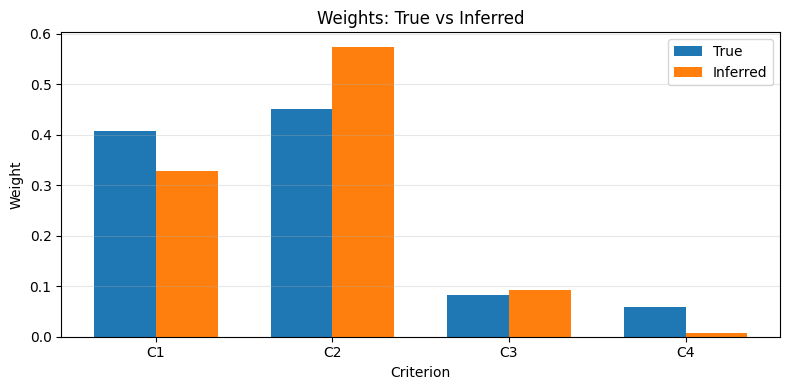

In [10]:
# ==================== NON-MONOTONIC UTA ====================

# Generate synthetic data
np.random.seed(7)
n, m, L = 100, 4, 5
X = np.random.randint(0, 100, size=(n, m))

print("="*60)
print("MONOTONIC UTA")
print("="*60)

# Generate monotonic ground truth
gt_mono = uta_gt(X, L=L, seed=2)
print(f"Ground truth weights: {np.round(gt_mono['weights'], 3)}")
print(f"Ground truth ranking (top 10): {gt_mono['ranking'][:10]}")

# Infer monotonic model
res_mono = uta_inf(X, order=gt_mono['ranking'], L=L, use_non_monotonic=True, gamma_weight=0.5)
print(f"\nInferred weights: {np.round(res_mono['weights'], 3)}")
print(f"Optimization status: {res_mono['status']}")
print(f"Objective value: {res_mono['obj']:.6f}")
print(f"Inferred ranking (top 10): {res_mono['ranking'][:10]}")

# Visualize monotonic results
print("\nGenerating visualizations...")
plot_value_functions(gt_mono, res_mono, mode="shape")
plot_weights(gt_mono, res_mono)


PAIRWISE AGREEMENT EVALUATION


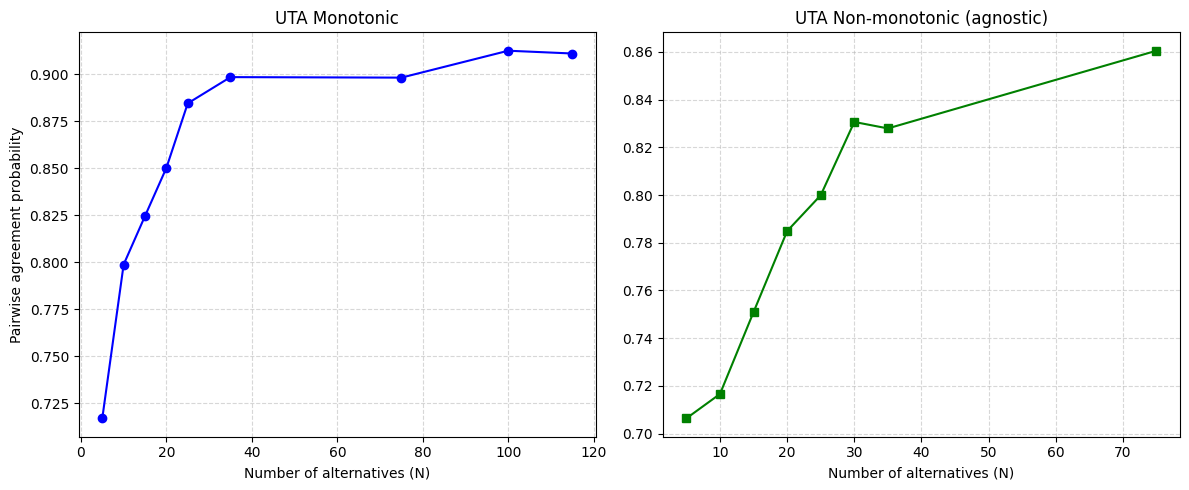

In [14]:
# ==================== COMPREHENSIVE EVALUATION ====================
import matplotlib.pyplot as plt

mono_means = []
nonmono_means = []

N1 = [5, 10, 15, 20, 25, 35, 75, 100, 115]
N2 = [5, 10, 15, 20, 25, 30, 35, 75]


print("\n" + "="*60)
print("PAIRWISE AGREEMENT EVALUATION")
print("="*60)

# 1) Monotonic UTA : GT 100% monotone, inférence monotone
# print("\n1. MONOTONIC UTA Performance (GT monotonic, inf monotonic):")
for n_alts in N1:
    result = run_protocol(
        n=n_alts, m=4, L=5,
        n_pairs=10_000, repeats=50,
        use_non_monotonic=False,   # inférence monotone
        gt_mode="monotonic",       # GT monotone
    )
    # print(f"  n={n_alts:3d}: {result['mean_acc']:.3%}")

    mono_means.append(result["mean_acc"])

# 2) Non-monotonic UTA : GT mixte (50% non-mono), inf agnostique non-monotone
# print("\n2. NON-MONOTONIC UTA Performance (GT mixed mono / non-mono, inf non-monotonic):")
for n_alts in N2:
    result = run_protocol(
        n=n_alts, m=4, L=5,
        n_pairs=10_000, repeats=50,
        use_non_monotonic=True,    # inférence avec gamma + epsilon variable
        gt_mode="mixed",           # GT : critères mixtes, décidés par uta_gt
    )
    # print(f"  n={n_alts:3d}: {result['mean_acc']:.3%}")

    nonmono_means.append(result["mean_acc"])

# --- Plotting results ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Plot 1 : Monotonic ---
axes[0].plot(N1, mono_means, marker='o', color='blue')
axes[0].set_title("UTA Monotonic")
axes[0].set_xlabel("Number of alternatives (N)")
axes[0].set_ylabel("Pairwise agreement probability")

axes[0].grid(True, which='both', linestyle='--', alpha=0.5)

# --- Plot 2 : Non-monotonic (agnostic) ---
axes[1].plot(N2, nonmono_means, marker='s', color='green')
axes[1].set_title("UTA Non-monotonic (agnostic)")
axes[1].set_xlabel("Number of alternatives (N)")

axes[1].grid(True, which='both', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [12]:
# ==================== GAMMA WEIGHT SENSITIVITY ANALYSIS ====================

def analyze_gamma_weights(X, gt, L=5):
    """
    Analyze how different gamma_weight values affect:
    1. Model complexity (total gamma)
    2. Discriminatory power (epsilon)
    3. Ranking accuracy
    """
    import matplotlib.pyplot as plt

    gamma_weights = [0.1, 0.3, 0.5, 0.7, 0.9]
    results = []

    for gw in gamma_weights:
        res = uta_inf(X, order=gt['ranking'], L=L,
                 eps=0.1,  # Consistent with main call
                 use_non_monotonic=True,
                 non_monotonic_criteria=gt['non_monotonic_criteria'],
                 gamma_weight=gw,
                 verbose=False)

        if res['status'] == GRB.OPTIMAL:
            total_gamma = np.sum(res['gamma_values']) if res['gamma_values'] is not None else 0
            epsilon_val = res['epsilon'] if res['epsilon'] is not None else 0

            # Compute ranking accuracy (Kendall's tau)
            from scipy.stats import kendalltau
            tau, _ = kendalltau(gt['ranking'], res['ranking'])

            results.append({
                'gamma_weight': gw,
                'total_gamma': total_gamma,
                'epsilon': epsilon_val,
                'kendall_tau': tau,
                'obj': res['obj']
            })

    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    gws = [r['gamma_weight'] for r in results]

    # Total gamma
    axes[0, 0].plot(gws, [r['total_gamma'] for r in results], 'o-', linewidth=2)
    axes[0, 0].set_xlabel('Gamma Weight')
    axes[0, 0].set_ylabel('Total Slope Variation')
    axes[0, 0].set_title('Complexity vs Gamma Weight')
    axes[0, 0].grid(True, alpha=0.3)

    # Epsilon
    axes[0, 1].plot(gws, [r['epsilon'] for r in results], 'o-', linewidth=2, color='orange')
    axes[0, 1].set_xlabel('Gamma Weight')
    axes[0, 1].set_ylabel('Epsilon (Separation)')
    axes[0, 1].set_title('Discriminatory Power vs Gamma Weight')
    axes[0, 1].grid(True, alpha=0.3)

    # Kendall's tau
    axes[1, 0].plot(gws, [r['kendall_tau'] for r in results], 'o-', linewidth=2, color='green')
    axes[1, 0].set_xlabel('Gamma Weight')
    axes[1, 0].set_ylabel("Kendall's Tau")
    axes[1, 0].set_title('Ranking Accuracy vs Gamma Weight')
    axes[1, 0].grid(True, alpha=0.3)

    # Trade-off: complexity vs discrimination
    axes[1, 1].scatter([r['total_gamma'] for r in results],
                      [r['epsilon'] for r in results],
                      c=gws, cmap='viridis', s=100)
    axes[1, 1].set_xlabel('Total Slope Variation')
    axes[1, 1].set_ylabel('Epsilon (Separation)')
    axes[1, 1].set_title('Complexity-Discrimination Trade-off')
    axes[1, 1].grid(True, alpha=0.3)
    cbar = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1])
    cbar.set_label('Gamma Weight')

    plt.tight_layout()
    plt.show()

    return results

# Run sensitivity analysis
print("\n" + "="*60)
print("GAMMA WEIGHT SENSITIVITY ANALYSIS")
print("="*60)

sensitivity_results = analyze_gamma_weights(X, gt_nonmono, L=5)
print("\nResults:")
for r in sensitivity_results:
    print(f"  γ_w={r['gamma_weight']:.1f}: "
          f"Σγ={r['total_gamma']:.3f}, "
          f"ε={r['epsilon']:.4f}, "
          f"τ={r['kendall_tau']:.3f}")


GAMMA WEIGHT SENSITIVITY ANALYSIS


NameError: name 'gt_nonmono' is not defined